In [1]:
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

In [2]:
import sys, os

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))

# Inference

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
)
from train import process_features
from utils import test_data

In [4]:
# from sklearn.model_selection import train_test_split

# # Split basic dataset from Jan-Nov for training, and Dec for inference
# df = pd.read_csv("../data/T1.csv", index_col="Date/Time")
# train, test = train_test_split(
#         df, test_size=0.088, shuffle=False
#     )

# pd.DataFrame(train).to_csv('../data/T1_train.csv')
# pd.DataFrame(test).to_csv('../data/T1_test.csv')

Load best performing Model and test file

In [5]:
test_df = test_data()
y_actual = test_df["active_power"]
prc_test_df = test_df.drop(["date_time", "active_power"], axis=1)
prc_test_df = process_features(prc_test_df)

model_path = "../models/wind_XGBoostRegression.pkl"
loaded_model = pickle.load(open(model_path, "rb"))
prediction = loaded_model.predict(prc_test_df)
test_df["prediction"] = prediction

Visualize

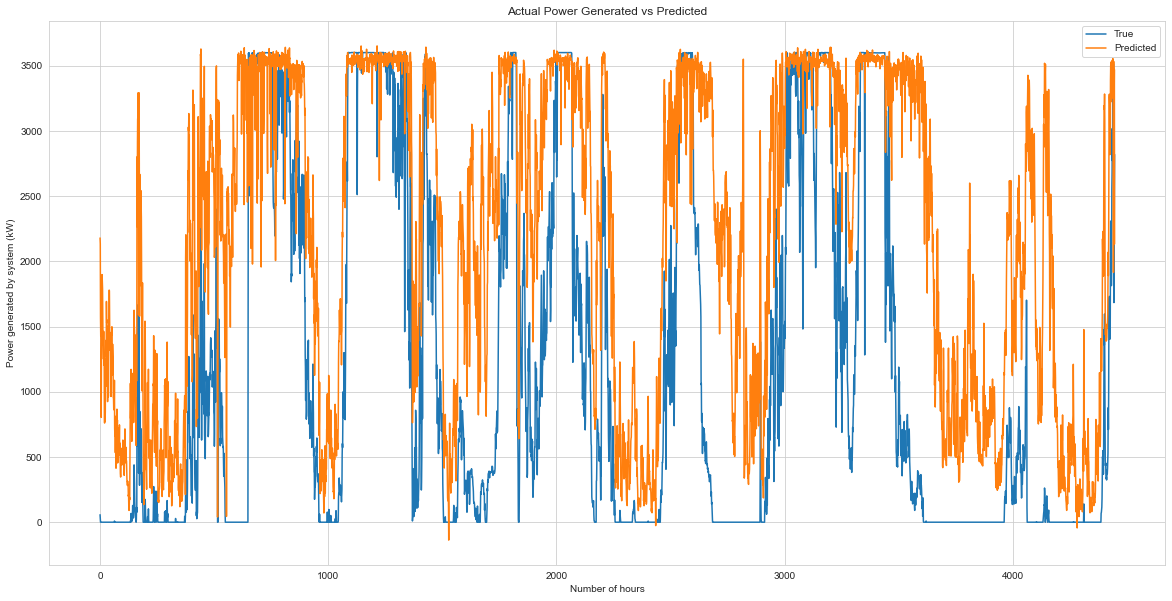

In [6]:
# line plot of observed vs predicted
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.plot(y_actual, label="True")
plt.plot(test_df["prediction"], label="Predicted")
plt.legend(loc="upper right")
plt.xlabel("Number of hours")
plt.ylabel("Power generated by system (kW)")
plt.title("Actual Power Generated vs Predicted")
plt.show()

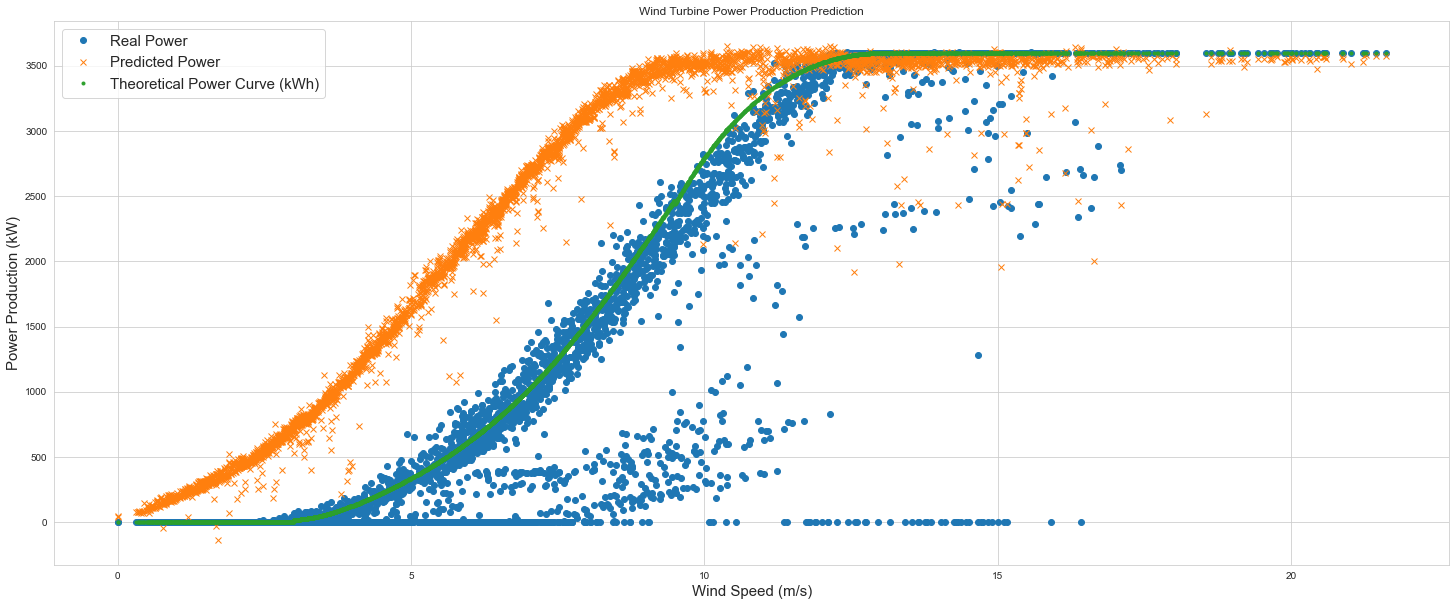

In [7]:
def graph_prediction(y_actual, y_predicted):
    y = y_actual
    y_total = y_predicted
    TP = test_df["theoretical_power"]
    number = len(test_df["wind_speed"])
    aa = [x for x in test_df["wind_speed"]]
    plt.figure(figsize=(25, 10))
    plt.plot(aa, y[:number], "o", label="Real Power")
    plt.plot(aa, y_total[:number], "x", label="Predicted Power")
    plt.plot(aa, TP[:number], ".", label="Theoretical Power Curve (kWh)")

    plt.xlabel("Wind Speed (m/s)", size=15)
    plt.ylabel("Power Production (kW)", size=15)
    plt.title("Wind Turbine Power Production Prediction")
    plt.legend(fontsize=15)
    plt.show()


graph_prediction(y_actual, prediction)

Alter predictions for thresholds.

In [8]:
def alter_preds(x):
    if x < 3.5:
        return 0
    if x > 25.5:
        return 3500


test_df["prediction"] = test_df.apply(
    lambda x: alter_preds(x["wind_speed"])
    if (x["wind_speed"] < 3.5 or x["wind_speed"] > 25.5)
    else x["prediction"],
    axis=1,
)

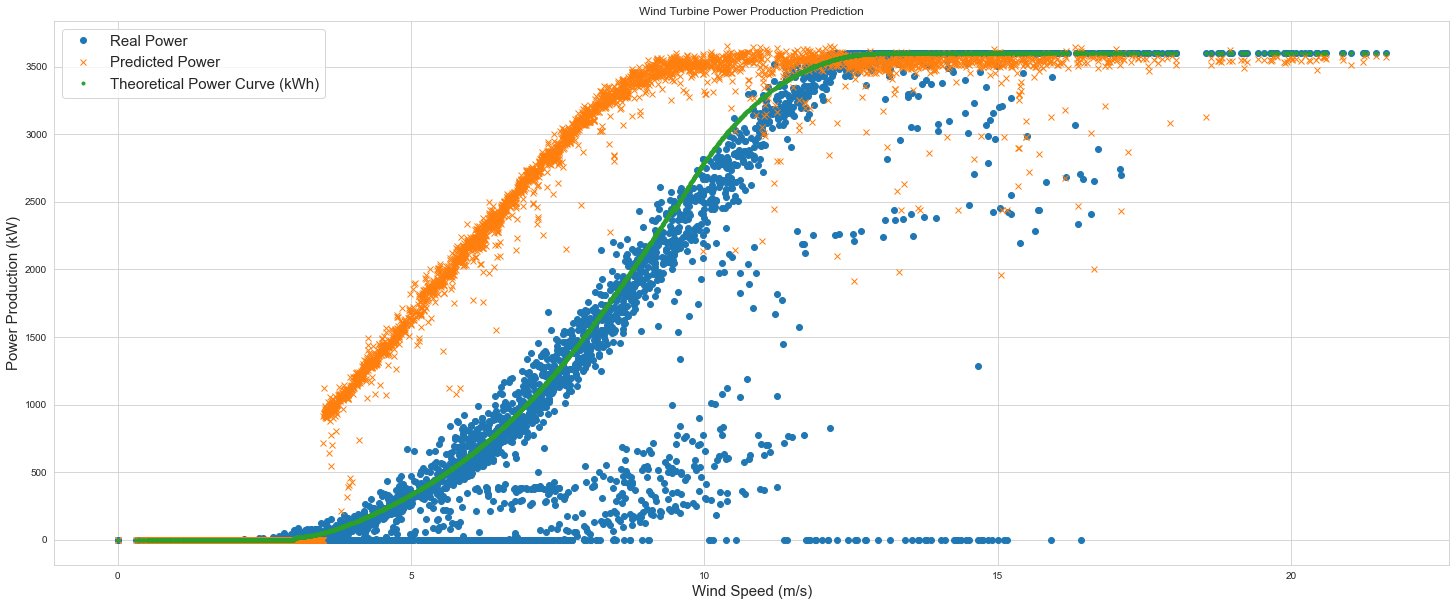

In [9]:
graph_prediction(y_actual, test_df["prediction"])

Evaluation

In [10]:
print(
    f'Mean Absolute Error      : {mean_absolute_error(test_df["active_power"], test_df["prediction"])}'
)
print(
    f'Mean Squared  Error      : {mean_squared_error(test_df["active_power"], test_df["prediction"])}'
)
print(
    f'Root Mean Squared  Error : {np.sqrt(mean_squared_error(test_df["active_power"], test_df["prediction"]))}'
)
print(
    f'R2 Score                 : {r2_score(test_df["active_power"], test_df["prediction"])}'
)
print(
    f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(test_df["active_power"], test_df["prediction"])}'
)

Mean Absolute Error      : 976.0214561520778
Mean Squared  Error      : 1827737.5385081363
Root Mean Squared  Error : 1351.9384373957773
R2 Score                 : 0.031951915619742755
Mean Absolute Percentage Error: 1.1545498152196628e+18


Model inference results on the unseen test dataset are not promising.

#### Output best performing Model inference results

In [11]:
# test_df = test_df.drop(['LV ActivePower (kW)'], axis=1)
test_df.to_csv("../data/output/XGBoostRegression_predictions.csv", index=False)

### Regression ML models inference

In [12]:
models_dict = {
    "LinearRegression": "../models/wind_LinearRegression.pkl",
    "LightGBMRegression": "../models/wind_LightGBMRegression.pkl",
}


def output_predictions(model_path, test_df, model_name):
    loaded_model = pickle.load(open(model_path, "rb"))
    prediction = loaded_model.predict(prc_test_df)
    test_df["prediction"] = prediction

    test_df["prediction"] = test_df.apply(
        lambda x: alter_preds(x["wind_speed"])
        if (x["wind_speed"] < 3.5 or x["wind_speed"] > 25.5)
        else x["prediction"],
        axis=1,
    )
    return test_df.to_csv(f"../data/output/{model_name}_predictions.csv", index=False)


for model_name, model_path in models_dict.items():
    output_predictions(model_path, test_df, model_name)

## Future Work

- add external environmental data for turbine
    - location is in Turkey, Yalova. The coordinates are X:668478 Y:4494833 UTM ED 50, 6 degrees
- when/ how to know to retrain deployed model?
    - compare latest pred eval metric against a threshold (rolling mean of actuals?)
